## Similitud Documental y predicción de etiquetas con score para Delitos Seguimiento

Fecha: 2023-09-08

Coder: Lenin G.  Falconí

**Objetivo:**
1. Analizar la similitud documental entre los relatos del dataset de policía $\mathbb{D}^{PN}$ y los del dataset de Fiscalía $\mathbb{D}^{FGE}  $
2. Utilizar dos técnicas para determinar el score de similitud
3. Realizar la predicción de la etiqueta de delitos seguimiento a partir del relato de Policía
4. Comparar en cuanto difiere la predicción sin re-entrenamiento del modelo partiendo de un texto diferente.

**Dataset**

El dataset a utilizar es el resultado de combinar los registros obtenidos de la Policía en conjunción con los tipos penales definidos en SIAF con la fecha de corte de 25 de agosto de 2023 y los tipos penales definidos por la Comisión Estadística i.e. $\mathbb{D}^{PN\cup FGE\cup CE}_{1210342 \times 119 }$

In [1]:
import pandas as pd
from src.utils import conectar_sql
from sqlalchemy import text
conx = conectar_sql()
table_name = 'relatosPoliciaSiaf_20230830'

query = text(f"select * from reportes.`{table_name}`;")
dataset_df = pd.read_sql(query, conx)
dataset_df.shape

2023-11-24 14:31:42.447116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


conectando con big data database....


(1210342, 119)

In [2]:
dataset_df.columns.tolist()

['index_policia',
 'NDD',
 'RelatoPolicia',
 'ANIO_REGISTRO_POLICIABD',
 'index_siaf',
 'Fecha_Registro',
 'Hora_Registro',
 'Fecha_Incidente',
 'Hora_Incidente',
 'Tentativa',
 'Direccion',
 'Presunto_Delito',
 'Presunto Delito (Circunstancia Modificatoria)',
 'Fiscalia',
 'Fiscalia_Especializada',
 'Ciudad',
 'PROVINCIA',
 'Canton',
 'Parroquia',
 'Tipo',
 'NyF',
 'numero_fiscalia',
 'edificio',
 'nombre_fiscal',
 'Fuero',
 'Etapa_procesal',
 'Estado_Procesal',
 'Fecha_estado_procesal',
 'IMPULSOS_DILIGENCIAS',
 'IMPULSOS',
 'Ultima_accion',
 'Fecha_Ultima_Accion',
 'APREHENDIDO',
 'SOSPECHOSO',
 'PROCESADO',
 'DETENIDO',
 'IMPUTADO',
 'numeroinf',
 'Tipo_incidente',
 'Fecha_IP_Inicio',
 'Fecha_IP_Fin',
 'Fecha_INS_Inicio',
 'Fecha_INS_Fin',
 'Tiempo_INS',
 'RelatoFiscalia',
 'PROVINCIA_INCIDENTE',
 'CANTON_INCIDENTE',
 'cantidadPalabras_RelatoPolicia',
 'cantidadPalabras_RelatoFiscalia',
 'RelatosIguales',
 'Fecha_Registro_comision',
 'Hora_Registro_comision',
 'Fecha_Incidente_comi

In [3]:
dataset_df[['NDD', 'Presunto_Delito', 'Tipo_Delito_PJ_comision', 'RelatoPolicia', 'cantidadPalabras_RelatoPolicia', 'RelatoFiscalia', 'cantidadPalabras_RelatoFiscalia', 'delitos_seguimiento_comision']].sample(5)

NDD     Presunto_Delito Tipo_Delito_PJ_comision  \
1123957  170101817042581                ROBO                    ROBO   
766190   090101818042355  ABUSO DE CONFIANZA                    None   
644113   030301820120041              ESTAFA                    None   
553754   070901820020017                ROBO                    ROBO   
22498    240301815020098               HURTO                    None   

                                             RelatoPolicia  \
1123957  ES EL CASO SEÑOR FISCAL QUE EL DÍA, HORA Y EN ...   
766190   SEÑOR FISCAL MI PADRE QUE RESPONDE A LOS NOMBR...   
644113   SEÑOR FISCAL EL DÍA DE AYER 30 DE DICIEMBRE DE...   
553754   ES EL CASO SÑEOR FISCAL QUE EL DIA DE AYER 03 ...   
22498                                                        

         cantidadPalabras_RelatoPolicia  \
1123957                             115   
766190                              300   
644113                               85   
553754                              108   
22498                                 0   

                                            RelatoFiscalia  \
1123957  ES  EL CASO  SEÑOR  FISCAL QUE EL DÍA,  HORA  ...   
766190   Se adjunta denuncia escrita,  con 4 anexos en ...   
644113   SEÑOR FISCAL EL DÍA DE AYER 30 DE DICIEMBRE DE...   
553754   ES EL CASO SÑEOR FISCAL QUE EL DIA DE AYER 03 ...   
22498    DENUNCIA REGISTADA EN LA FISCLIA MEDIANTE OFIC...   

         cantidadPalabras_RelatoFiscalia delitos_seguimiento_comision  
1123957                              121             ROBO A DOMICILIO  
766190                                10                         None  
644113                                89                         None  
553754                               113              ROBO A PERSONAS  
22498                                  9                         None

## Similitud de Relatos Policía vs Fiscalía

Se aplica las siguientes técnicas para calcular la similitud de los relatos

In [4]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopWords = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/falconiel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import transformers
import torch
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel, AutoTokenizer
from transformers import AutoModel
model_ckpt = "distilbert-base-multilingual-cased"

# from bert_score import score

def cosine_similarity_tfidf(text1, text2):
  """Calculates the cosine similarity between two documents using TF-IDF."""
  vectorizer = TfidfVectorizer(stop_words=stopWords) # to adapt to spanish
  vectors = vectorizer.fit_transform([text1, text2])
  similarity = cosine_similarity(vectors[0], vectors[1])
  return similarity.item()

def cosine_similarity_word2vec(text1, text2):
  """Calculates the cosine similarity between two documents using word2vec."""
  sentences = [text1.split(), text2.split()]
  model = Word2Vec(sentences, min_count=1)
  embeddings1 = model.wv[text1.split()].mean(axis=0).reshape(1,-1)
  embeddings2 = model.wv[text2.split()].mean(axis=0).reshape(1,-1)
  # similarity = np.dot(embeddings1, embeddings2) / (np.linalg.norm(embeddings1) * np.linalg.norm(embeddings2))
  similarity = cosine_similarity(embeddings1, embeddings2)
  return similarity.item()

def cosine_similarity_bert(text1, text2):
  """Calculates the cosine similarity between two documents using BERT."""
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  model = BertModel.from_pretrained('bert-base-uncased')
  encoded_input1 = tokenizer(text1, return_tensors='pt')
  encoded_input2 = tokenizer(text2, return_tensors='pt')
  output1 = model(**encoded_input1)
  output2 = model(**encoded_input2)
  embeddings1 = output1.last_hidden_state.detach().numpy()
  embeddings2 = output2.last_hidden_state.detach().numpy()
  # print(embeddings1)
  # similarity = cosine_similarity(embeddings1, embeddings2)
  similarity_score = cosine_similarity(embeddings1.mean(axis=1), embeddings2.mean(axis=1))
  return similarity_score.item()

def cosine_similarity_bert_model(text1, text2, model=model_ckpt):
  """Calculates the cosine similarity between two documents using bert but
    specifying the model to be used
  """
  tokenizer = AutoTokenizer.from_pretrained(model)
  bert_model = AutoModel.from_pretrained(model)
  # Tokeniza el texto y trunca si supera los 512 tokens
  # inputs = tokenizer.encode(text, truncation=True, max_length=512)
  encoded_input1 = tokenizer(text1, truncation=True, max_length=256, return_tensors='pt')
  encoded_input2 = tokenizer(text2, truncation=True, max_length=256, return_tensors='pt')
  output1 = bert_model(**encoded_input1)
  output2 = bert_model(**encoded_input2)
  embeddings1 = output1.last_hidden_state.detach().numpy()
  embeddings2 = output2.last_hidden_state.detach().numpy()
  # print(embeddings1.shape, embeddings2.shape)
  similarity_score = cosine_similarity(embeddings1.mean(axis=1), embeddings2.mean(axis=1))
  # similarity_score = cosine_similarity(embeddings1[0], embeddings2[0])
  # print(similarity_score.shape)
  return similarity_score.item()

sentences = ["El perro bebió té inglés.", "Mary tenía un libro de inglés."]
text1 = sentences[0]
text2 = sentences[1]

similarity_tfidf = cosine_similarity_tfidf(text1, text2)
similarity_word2vec = cosine_similarity_word2vec(text1, text2)
similarity_bert = cosine_similarity_bert(text1, text2)
similarity_distil_bert = cosine_similarity_bert_model(text1, text2, model=model_ckpt)

print("The cosine similarity between the two documents using TF-IDF is:", similarity_tfidf)
print("The cosine similarity between the two documents using word2vec is:", similarity_word2vec)
print("The cosine similarity between the two documents using BERT is:", similarity_bert)
print("The cosine similarity between the two documents using DISTIL-BERT is:", similarity_distil_bert)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vo

The cosine similarity between the two documents using TF-IDF is: 0.17077611319011649
The cosine similarity between the two documents using word2vec is: 0.11319118738174438
The cosine similarity between the two documents using BERT is: 0.8455851078033447
The cosine similarity between the two documents using DISTIL-BERT is: 0.6644577980041504


A fin de que los relatos se procesen de manera similar se aplicará el formateo del texto que se usa para la predicción  desde el modelo de machine learning

In [6]:
from src.utils import format_crimestory
format_crimestory(dataf=dataset_df,
relato_label='RelatoPolicia')
format_crimestory(dataf=dataset_df,
relato_label='RelatoFiscalia')

In [7]:
dataset_df.RelatoFiscalia.isna().sum(), dataset_df.RelatoPolicia.isna().sum()

(0, 0)

In [8]:
dataset_df.cantidadPalabras_RelatoFiscalia.min(), dataset_df.cantidadPalabras_RelatoPolicia.min()

(0, 0)

No se puede realizar la comparacion en los casos en que no existe texto de policita o de fiscalia por ende se debe formar un nuevo dataset con los registros que sí tienen texto. Además por problemas de limitación de memoria se debe calcular una muestra representativa de los datos. Para esto se obtiene la siguiente tamaño de muestra con las condiciones indicadas y la ecuación:

$n =\frac{z^2p(1-p) }{\epsilon^2N+z^2p(1-p)}N $

Sample size: 46947

This means 46947 or more measurements/surveys are needed to have a confidence level of 99.999% that the real value is within ±1% of the measured/surveyed value.

In [9]:
# dataset_df_sample = dataset_df.sample(int(0.7*dataset_df.shape[0]))
# dataset_df_sample.shape
# del dataset_df_sample

In [10]:
# reduced_columns = ['NDD', 'RelatoPolicia', 'cantidadPalabras_RelatoPolicia', 'RelatoFiscalia', 'cantidadPalabras_RelatoFiscalia']
dataset_df_texto = dataset_df[(dataset_df.cantidadPalabras_RelatoPolicia>=50)&(dataset_df.cantidadPalabras_RelatoFiscalia>=50)]
dataset_df_texto.shape

(785513, 119)

Sample size: 45983

This means 45983 or more measurements/surveys are needed to have a confidence level of 99.999% that the real value is within ±1% of the measured/surveyed value.

Sample size: 16297

This means 16297 or more measurements/surveys are needed to have a confidence level of 99% that the real value is within ±1% of the measured/surveyed value.

Sample size: 6748

This means 6748 or more measurements/surveys are needed to have a confidence level of 90% that the real value is within ±1% of the measured/surveyed value.

https://www.calculator.net/sample-size-calculator.html?type=1&cl=90&ci=1&pp=50&ps=785513&x=Calculate

In [11]:
del dataset_df

In [12]:
SAMPLE_SIZE = 6000
dataset_df_texto_sample = dataset_df_texto[['NDD', 
                                            'RelatoFiscalia', 
                                            'cantidadPalabras_RelatoFiscalia',
                                            'RelatoPolicia',
                                            'cantidadPalabras_RelatoPolicia',
                                            'Presunto_Delito',
                                            'Tipo_Delito_PJ_comision',
                                            'delitos_seguimiento_comision']].sample(SAMPLE_SIZE)
dataset_df_texto_sample.shape

(6000, 8)

In [13]:
from datasets import Dataset
dataset_df_texto_sample_hf = Dataset.from_pandas(dataset_df_texto_sample)


In [14]:
# dataset_df_texto['cosine_similarity'] = dataset_df_texto.apply(lambda x: cosine_similarity(x.RelatoPolicia, x.RelatoFiscalia), axis=1)
# dataset_df_texto_sample['word2vec_similarity'] = dataset_df_texto_sample.apply(lambda x: cosine_similarity_word2vec(x.RelatoPolicia, x.RelatoFiscalia), axis=1)
# dataset_df_texto_sample['cosine_similarity_bert_model'] = dataset_df_texto_sample.apply(lambda x: cosine_similarity_bert_model(x.RelatoPolicia, x.RelatoFiscalia, model=model_ckpt), axis=1)

dataset_df_texto_sample_hf = dataset_df_texto_sample_hf.map(lambda example: {'word2vec_similarity': cosine_similarity_word2vec(example['RelatoPolicia'], example['RelatoFiscalia'])})



  0%|          | 0/6000 [00:00<?, ?ex/s]

In [15]:
dataset_df_texto_sample_hf = dataset_df_texto_sample_hf.map(lambda example:{'cosine_similarity_bert_model': cosine_similarity_bert_model(text1=example['RelatoPolicia'],
                                                                                                                                         text2=example['RelatoFiscalia'],
                                                                                                                                         model=model_ckpt)})


  0%|          | 0/6000 [00:00<?, ?ex/s]

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'voca

Convert the dataset back to a pandas dataframe

In [17]:
del dataset_df_texto_sample

In [18]:
dataset_df_texto_sample = dataset_df_texto_sample_hf.to_pandas()

In [19]:
dataset_df_texto_sample.word2vec_similarity.describe()

count    6000.000000
mean        0.957418
std         0.073233
min         0.310206
25%         0.961602
50%         0.975714
75%         0.984985
max         1.000000
Name: word2vec_similarity, dtype: float64

Text(0.5, 1.0, 'Similaridad word2vec histograma')

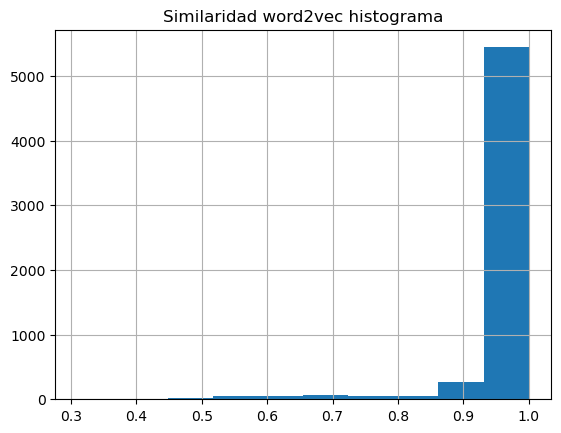

In [20]:
import matplotlib.pyplot as plt
dataset_df_texto_sample['word2vec_similarity'].hist().plot()
plt.title('Similaridad word2vec histograma')

In [21]:
dataset_df_texto_sample['cosine_similarity_bert_model'].describe()

count    6000.000000
mean        0.987899
std         0.023865
min         0.780015
25%         0.990691
50%         0.995396
75%         0.997255
max         1.000000
Name: cosine_similarity_bert_model, dtype: float64

Text(0.5, 1.0, 'Similitud Bert histograma')

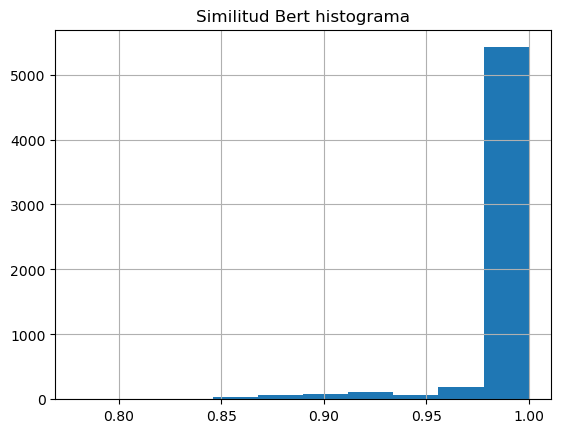

In [22]:
dataset_df_texto_sample['cosine_similarity_bert_model'].hist().plot()
plt.title('Similitud Bert histograma')

## Predicciones
Se busca revisar si la predicción realizada sobre el dataset con el relato de policia es diferente de la realizada con el relato de fiscalía


In [23]:
from src.utils import load_text_classification_model
PATH_MODEL_SEGUIMIENTOS = '/home/falconiel/ML_Models/robbery_tf20221113'
PATH_MODEL_VALIDADOS = '/home/falconiel/ML_Models/robbery_tf20230213'
model_ckpt = "distilbert-base-multilingual-cased"
SEQ_LEN = 300
THRESHOLD_WORDS_QTY = 50

modelo_delitos_seguimiento = load_text_classification_model(path2model=PATH_MODEL_SEGUIMIENTOS,
                                                            seq_len=SEQ_LEN,
                                                            threshold_words_qty=THRESHOLD_WORDS_QTY)

2023-11-25 15:36:36.086702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 15:36:36.114535: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /home/falconiel/ML_Models/robbery_tf20221113.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [24]:
from src.utils import predict_text_class_tqdm
predict_text_class_tqdm(dataf=dataset_df_texto_sample,
                    model=modelo_delitos_seguimiento,
                    label_relato='RelatoPolicia',
                    label_name='delitosSeguimientoPolicia',
                    words_qty_label='cantidadPalabras_RelatoPolicia',
                    threshold_words_qty=THRESHOLD_WORDS_QTY)

100%|██████████| 6000/6000 [24:48<00:00,  4.03it/s]


In [25]:
from src.utils import predict_text_class_tqdm
predict_text_class_tqdm(dataf=dataset_df_texto_sample,
                    model=modelo_delitos_seguimiento,
                    label_relato='RelatoFiscalia',
                    label_name='delitosSeguimientoFiscalia',
                    words_qty_label='cantidadPalabras_RelatoFiscalia',
                    threshold_words_qty=THRESHOLD_WORDS_QTY)

100%|██████████| 6000/6000 [26:42<00:00,  3.74it/s]


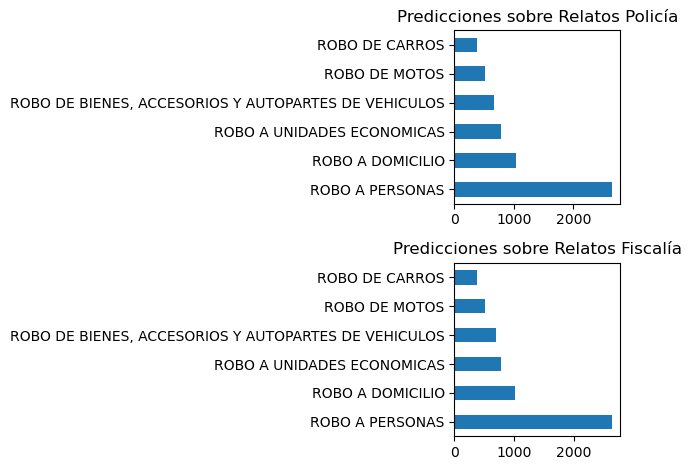

In [26]:
# Create a figure with 2 subplots (vertically stacked)
fig, axs = plt.subplots(2, 1)

# Plot the value counts of the first column in the first subplot
dataset_df_texto_sample['delitosSeguimientoPolicia'].value_counts().plot.barh(ax=axs[0])
axs[0].set_title('Predicciones sobre Relatos Policía')

# Plot the value counts of the second column in the second subplot
dataset_df_texto_sample['delitosSeguimientoFiscalia'].value_counts().plot.barh(ax=axs[1])
axs[1].set_title('Predicciones sobre Relatos Fiscalía')

# Display the plot
plt.tight_layout()
plt.show()

In [27]:
print(f"predicciones sobre relato fiscalia en el dataset")
dataset_df_texto_sample.delitosSeguimientoFiscalia.value_counts()

predicciones sobre relato fiscalia en el dataset


ROBO A PERSONAS                                         2633
ROBO A DOMICILIO                                        1019
ROBO A UNIDADES ECONOMICAS                               774
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS     690
ROBO DE MOTOS                                            514
ROBO DE CARROS                                           370
Name: delitosSeguimientoFiscalia, dtype: int64

In [28]:
print(f"predicciones sobre relato fiscalia en el dataset")
dataset_df_texto_sample.delitosSeguimientoPolicia.value_counts()

predicciones sobre relato fiscalia en el dataset


ROBO A PERSONAS                                         2650
ROBO A DOMICILIO                                        1027
ROBO A UNIDADES ECONOMICAS                               778
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS     665
ROBO DE MOTOS                                            509
ROBO DE CARROS                                           371
Name: delitosSeguimientoPolicia, dtype: int64

In [29]:
dataset_df_texto_sample[['NDD', 'RelatoPolicia', 'RelatoFiscalia', 'cantidadPalabras_RelatoPolicia', 'cantidadPalabras_RelatoFiscalia', 'delitosSeguimientoPolicia', 'delitosSeguimientoFiscalia']].sample(5)

NDD                                      RelatoPolicia  \
151   121201822100027  que el dí a 16 de octubre del 2022 a las 07h00...   
5355  061001815110025  es el caso señor fiscal que soy policia nacion...   
1203  170101814113001  es el caso señor fiscal que me encontraba en l...   
2914  090101816044376  señor fiscal el día 22 de abril del 2016 aprox...   
726   170101816062161  es el caso señor fiscal que el día 12 de junio...   

                                         RelatoFiscalia  \
151   que el día 16 de octubre del 2022 a las 07h00 ...   
5355  es el caso señor fiscal que soy policia nacion...   
1203  es el caso señor fiscal que me encontraba en l...   
2914  señor fiscal el día 22 de abril del 2016 aprox...   
726   es el caso señor fiscal que el día 12 de junio...   

      cantidadPalabras_RelatoPolicia  cantidadPalabras_RelatoFiscalia  \
151                              182                              190   
5355                             172                              182   
1203                              80                               84   
2914                              91                               93   
726                              217                              229   

       delitosSeguimientoPolicia  delitosSeguimientoFiscalia  
151                ROBO DE MOTOS               ROBO DE MOTOS  
5355             ROBO A PERSONAS              ROBO DE CARROS  
1203             ROBO A PERSONAS             ROBO A PERSONAS  
2914  ROBO A UNIDADES ECONOMICAS  ROBO A UNIDADES ECONOMICAS  
726             ROBO A DOMICILIO            ROBO A DOMICILIO

In [30]:
dataset_df_texto_sample.delitos_seguimiento_comision.isna().sum(), dataset_df_texto_sample.shape

(2193, (6000, 15))

## Evaluación de Predicciones

Para realizar la evaluación de las predicciones podemos considerar delitosSeguimientoPolicia y delitosSeguimientoFiscalia como $\hat{y}_{policia}  $ y $\hat{y}_{fge}  $ donde la variable delitos_seguimiento_comision se consiera el Ground Truth. Para esto dado que $\exists $ filas $r_i$ donde delitos_seguimiento_comision no tienen un valor definido, se procede a eliminar estas filas para la evaluacón a fin de realizar una comparación estable. A fin de no disponer de cortes en la ejecución del programa se recomienda salvar en disco la información existente

In [32]:
# dataset_df_texto_sample.to_csv('data/processed/resultadosDatasetSimilitudPrediccionesTextoPoliciaFGE.csv', index=False)

In [49]:
# from src.utils import save_df_in_sql
# save_df_in_sql(name_table='resultadoSimilitudRelatoPoliciaFiscalia',
#                dataf=dataset_df_texto_sample)

In [33]:
dataset_df_texto_sample_2eval = dataset_df_texto_sample[-dataset_df_texto_sample.delitos_seguimiento_comision.isna()]
dataset_df_texto_sample.shape, dataset_df_texto_sample_2eval.shape

((6000, 15), (3807, 15))

In [35]:
from sklearn.metrics import classification_report
print("Reporte de Clasificación de predicciones sobre relato Fiscalia")
print(classification_report(y_true=dataset_df_texto_sample_2eval.delitos_seguimiento_comision,
y_pred=dataset_df_texto_sample_2eval.delitosSeguimientoFiscalia))

Reporte de Clasificación de predicciones sobre relato Fiscalia
                                                      precision    recall  f1-score   support

                                    ROBO A DOMICILIO       0.80      0.92      0.86       564
                                     ROBO A PERSONAS       0.90      0.95      0.93      1458
                          ROBO A UNIDADES ECONOMICAS       0.61      0.88      0.72       245
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS       0.85      0.95      0.89       493
                                      ROBO DE CARROS       0.93      0.93      0.93       312
                                       ROBO DE MOTOS       0.98      0.95      0.96       415
                                     SIN INFORMACION       0.00      0.00      0.00       320

                                            accuracy                           0.86      3807
                                           macro avg       0.72      0.80      0.76      

/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [36]:
from sklearn.metrics import classification_report
print("Reporte de Clasificación de predicciones sobre relato Policía")
print(classification_report(y_true=dataset_df_texto_sample_2eval.delitos_seguimiento_comision,
y_pred=dataset_df_texto_sample_2eval.delitosSeguimientoPolicia))

Reporte de Clasificación de predicciones sobre relato Policía
                                                      precision    recall  f1-score   support

                                    ROBO A DOMICILIO       0.80      0.93      0.86       564
                                     ROBO A PERSONAS       0.90      0.95      0.93      1458
                          ROBO A UNIDADES ECONOMICAS       0.58      0.88      0.70       245
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS       0.86      0.93      0.89       493
                                      ROBO DE CARROS       0.89      0.90      0.90       312
                                       ROBO DE MOTOS       0.97      0.93      0.95       415
                                     SIN INFORMACION       0.00      0.00      0.00       320

                                            accuracy                           0.85      3807
                                           macro avg       0.72      0.79      0.75      3

/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

## Amenazas a la Validez

El presente estudio dispone como amaneza a la validez la restricción derivada de los recursos de hardware disponibles (i.e. tamaño de RAM y GPUs) de donde a fin de poder presentar un resultado computable se procedió a obtener una muestra aleatoria con un nivel de confianza del 90% con un error esperado del 1% sobre 785513 registros, lo que recomienda usar un tamaño de muestra de 6748. Sin embargo, el dataset se redondeó al entero inferior más próximo que sería 6000. Este cambio afecta en el error esperado que sería en realidad del 1.1%

## Conclusiones

* Para la comparación de textos de policía $text_{policia}$ y de fiscalía $text_{fge}$ se utilizaron dos métricas de similitud. La una está basada en word2vec y la otra en transformadores utilizando concretamente distil_bert que dispone de entrenamiento en lenguaje español. De los histogramas presentados se observa que en promedio ambos textos se consideran similares con una media de 0.97 entre ambos valores. También se observa que el 75% de los datos supera el 0.95 de similitud en dos técnicas distintas

* Adicional a esto se realiza la comparación de predicciones derivadas de ambos relatos. Para esto se descartaron textos inferiores a 50 palabras y las filas en donde la comisión no dispone de valor registrado. Puede observarse que las variaciones relativas entre el relato de policía y el de fiscalía son mínimas. En promedio se podría hablar de una diferencia global entre ambos del 0.16%

* Con respecto a las métricas de evaluación del clasificador se observa un rendimiento general de 0.86 para el relato de Fiscalía y 0.85 para el relato de Policía. En donde la diferencia menor se puede explicar porque el modelo está entrenado en relato de fiscalía. Sin emargo, se puede observar que la inferencia y capacidad de generalización del modelo no está supedidata al origen del relato por cuanto las expresiones idiomáticas más o menos serán las mismas que tengan relación con la categoría del delito.

* De lo anterior se confirmaría que la manera de mejorar al modelo no está en entrenar con datos de policia o de fiscalía sino en entrenar con la maor cantidad de datos posibles lo que implica un mayor consumo de hardware

In [41]:
valores_fge = dataset_df_texto_sample.delitosSeguimientoFiscalia.value_counts().values
valores_policia = dataset_df_texto_sample.delitosSeguimientoPolicia.value_counts().values

In [42]:
valores_fge.sum(), valores_policia.sum()

(6000, 6000)

In [45]:
# resultado de variación relativa en % por categoría
resp = np.abs(valores_fge-valores_policia)/valores_fge.sum()*100
resp

array([0.28333333, 0.13333333, 0.06666667, 0.41666667, 0.08333333,
       0.01666667])

In [46]:
resp.mean()

0.16666666666666666